In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import gmaps
import requests
import json
from config import gkey

In [2]:
happiness_2021 = pd.read_csv('cleaned_happiness_2021.csv')

# Data Overview

## World Happiness Report

The World Happiness Report is put together annually by the Sustainable Development Solutions Network, a non-profit created by the United Nations. It consists of a survey in which particpants are asked to rank themselves on the Cantril Ladder Scale as well as on other variables about their lives. This gives a glimpse into the satisfaction different nations have with their well being and quality of life as well as factors that likely affect that.

### The Cantril Ladder Scale

Developed by pioneering social researcher Dr. Hadley Cantril, consists of the following:

>Please imagine a ladder with steps numbered from zero at the bottom to 10 at the top.  
The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you.  
On which step of the ladder would you say you personally feel you stand at this time?

from: [gallup.com](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx)

### Global view of happiness scores

In [3]:
gmaps.configure(api_key = gkey)
fig = gmaps.figure()

all_locations = happiness_2021[["Latitude","Longitude"]]
all_happiness = happiness_2021['Happiness score']
                                        
figure_layout = {
    'width': '1000px',
    'height': '500px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto',
}
                             
fig = gmaps.figure(layout=figure_layout, center=(26.820553, 30.802498), zoom_level=1.75)

heat_layer = gmaps.heatmap_layer(all_locations, weights=all_happiness, 
                                 dissipating=False, max_intensity=10,
                                 point_radius = 3,gradient=['rgba(0,0,0,0)','rgb(2, 199, 22)','yellow','red'])

fig.add_layer(heat_layer)

fig


Figure(layout=FigureLayout(border='1px solid black', height='500px', margin='0 auto 0 auto', padding='1px', wi…

## Hypothesis

We are looking to answer whether or not Gross Domestic Product (GDP) per capita, social support, healthy life expectancy, or freedom to make life choices affects happiness scores. 

## Summary of Analysis

We found that all four variables inspected have statistically significant affects on happiness score, all in a positive direction. 

In [4]:
corr = happiness_2021[["Happiness score","GDP per capita","Social support",'Healthy life expectancy',"Freedom to make life choices"]].corr()
corr = corr.style.background_gradient(cmap='Purples')
corr

,Happiness score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices
Happiness score,1.000000,0.795247,0.808799,0.711411,0.579028
GDP per capita,0.795247,1.000000,0.767490,0.856166,0.329454
Social support,0.808799,0.767490,1.000000,0.713057,0.429402
Healthy life expectancy,0.711411,0.856166,0.713057,1.000000,0.340498
Freedom to make life choices,0.579028,0.329454,0.429402,0.340498,1.000000


## GDP

To start off, let's look at where our GDP per capita is clustered.

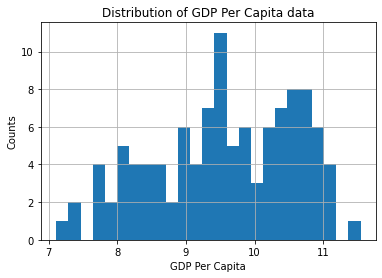

In [5]:
# Let's see where the data is at
happiness_2021["GDP per capita"].hist(bins=25)

plt.xlabel("GDP Per Capita")
plt.ylabel("Counts")
plt.title("Distribution of GDP Per Capita data")

plt.show()

In the cleanup phase, we removed countries that had "NA" for any of our four major categories. If a country had NA, the surveyors didn't feel as if they could come up with an accurate measure, so all of our GDP per capita data is accurate. Additionally, now that we can see where the data is clustered, no one country has an incredibly high or low value. In conclusion, we can safely assume ***there are no outliers.***

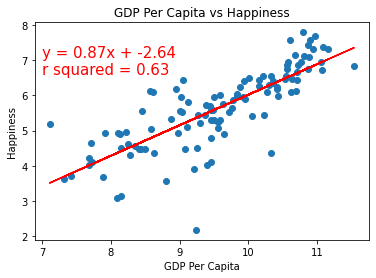

In [6]:
# Let's graph this compared to Happiness Score
x_axis = happiness_2021["GDP per capita"]
y_axis = happiness_2021["Happiness score"]


(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"
rsquared = f"r squared = {round(rvalue * rvalue, 2)}"

plt.plot(x_axis, regress_values, color='red')
plt.annotate(line_eq, (7,7.1), fontsize=15, color="red")
plt.annotate(rsquared, (7,6.6), fontsize=15, color="red")

plt.title("GDP Per Capita vs Happiness")
plt.ylabel("Happiness")
plt.xlabel("GDP Per Capita")

plt.scatter(x_axis, y_axis)
plt.show()

One can certainly see a general trend with happiness increasing as GDP per capita increases. However, it is still necessary to perform a test. For this data, we'll use an ANOVA test, grouping the data into rough thirds by GDP per capita and comparing the populations.

In [7]:
# Extract individual groups
group0 = happiness_2021[happiness_2021["GDP per capita"] < 8.75]["Happiness score"]
group1 = happiness_2021[happiness_2021["GDP per capita"].between(8.75, 10.25, inclusive='both')]["Happiness score"]
group2 = happiness_2021[happiness_2021["GDP per capita"] > 10.25]["Happiness score"]

# Perform the ANOVA
st.f_oneway(group0, group1, group2)

F_onewayResult(statistic=66.84719963035289, pvalue=1.4574777104746294e-19)

With a P value much lower than .05, we can comfortably reject the null hypothesis that GDP per capita has no effect on happiness score.

## Life Expectancy

# Hypothesis:

>When healthy life expectancy is high, there is a measurable increase in the Cantrill happiness score. <br>Null Hypothesis (H<sub>0</sub>):  When healthy life expectancy is high, there is no measurable impact in the Cantrill happiness score whatsoever.<br>If p-value is < 0.05 then we reject the null hypothesis. 

In [8]:
grF = happiness_2021[happiness_2021['Healthy life expectancy'] < 60]["Happiness score"]
grD = happiness_2021[happiness_2021['Healthy life expectancy'].between(59.99, 65.40, inclusive='both')]["Happiness score"]
grC = happiness_2021[happiness_2021['Healthy life expectancy'].between(65.40, 67.20, inclusive='both')]["Happiness score"]
grB = happiness_2021[happiness_2021['Healthy life expectancy'].between(67.20, 70.33, inclusive='both')]["Happiness score"]
grA = happiness_2021[happiness_2021['Healthy life expectancy'] > 70.33]["Happiness score"]
st.f_oneway(grA, grB, grC, grD, grF)

F_onewayResult(statistic=31.559923638910274, pvalue=2.9603982004555786e-17)

### Using the ANOVA test, H<sub>0</sub> is rejected.

In [9]:
happiness_2021['Healthy life expectancy'].describe()

count    110.000000
mean      65.305000
std        5.458450
min       51.299999
25%       61.862499
50%       66.450001
75%       69.299999
max       74.349998
Name: Healthy life expectancy, dtype: float64

#### During data cleaning & exploration
>in a challenging to read series of box plots, the minimum to maximum life expectancy range became a point of interest.
23 years of Life expectancy is the full range of this data ***Or*** Nearly 1/3 less life to be lived.

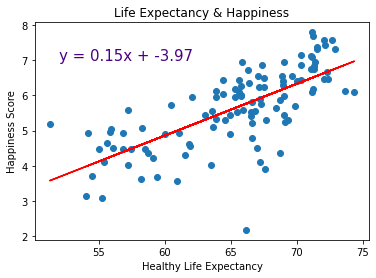

In [10]:
x_values = happiness_2021['Healthy life expectancy']
y_values = happiness_2021['Happiness score']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(52,7),fontsize=15,color="indigo")
plt.xlabel("Healthy Life Expectancy")
plt.ylabel("Happiness Score")
plt.title("Life Expectancy & Happiness")
plt.show()

In [11]:
pr = round(st.pearsonr(x_values,y_values)[0],2)
if pr > 0.7 :
    link = "strong"
else :
    link = "not strong"
    
print(f'The Pearson corr. coefficient between Longevity and Happiness is {pr}, a {link} link between the two factors.')

The Pearson corr. coefficient between Longevity and Happiness is 0.71, a strong link between the two factors.


## Freedom

Per the World Happiness Report: 
>Freedom to make life choices is the national average of a binary response (0=no, 1=yes) to the question "Are you satisfied or dissatisfied with your freedom to choice what to do with your life?

### Freedom to Make Life Choices Survey Results Distribution

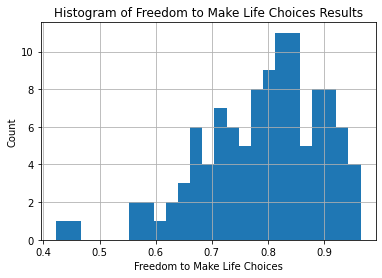

count    110.000000
mean       0.790595
std        0.107183
min        0.422697
25%        0.724480
50%        0.809086
75%        0.869746
max        0.965093
Name: Freedom to make life choices, dtype: float64


In [12]:
happiness_2021['Freedom to make life choices']. hist(bins=25)

plt.xlabel('Freedom to Make Life Choices')
plt.ylabel('Count')
plt.title('Histogram of Freedom to Make Life Choices Results')
plt.show()
print(happiness_2021['Freedom to make life choices'].describe())

### Regression

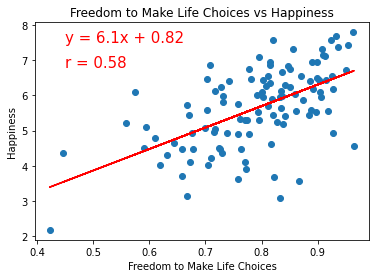

In [13]:
x_axis = happiness_2021['Freedom to make life choices']
y_axis = happiness_2021['Happiness score']

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = f'y = {round(slope, 2)}x + {round(intercept, 2)}'

pearson_r = st.pearsonr(x_axis, y_axis)

pr = f'r = {round(pearson_r[0],2)}'

plt.plot(x_axis, regress_values, color='red')
plt.annotate(line_eq, (0.45,7.5), fontsize=15, color='red')
plt.annotate(pr, (0.45,6.8), fontsize=15, color='red')

plt.title('Freedom to Make Life Choices vs Happiness')
plt.ylabel('Happiness')
plt.xlabel('Freedom to Make Life Choices')

plt.scatter(x_axis, y_axis)
plt.show()

### Hypothesis Testing


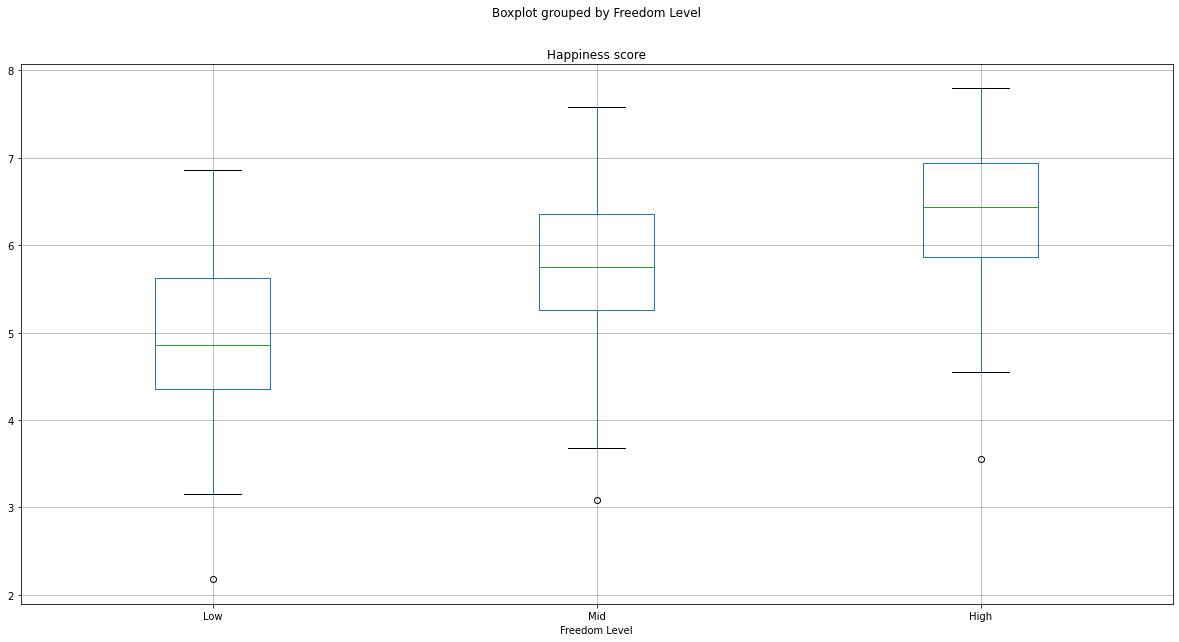

In [14]:
#sorting by freedom scores and creating three groups
freedom_sort = happiness_2021[['Freedom to make life choices', 'Happiness score']].copy()
freedom_sort = freedom_sort.sort_values(by=['Freedom to make life choices'], ascending=True)
#freedom_sort = freedom_sort.reset_index
freedom_low = freedom_sort.iloc[0:36]
freedom_mid = freedom_sort.iloc[36:73]
freedom_high = freedom_sort.iloc[73:110]

bins = [0, 0.7573, 0.83811, 1]
group_names = ['Low', "Mid", "High"]

freedom_sort["Freedom Level"] = pd.cut(freedom_sort["Freedom to make life choices"], bins, labels=group_names, include_lowest=True)
freedom_sort

freedom_sort.boxplot('Happiness score', by='Freedom Level', figsize=(20,10))
plt.show()

hypothesis_test = st.f_oneway(freedom_low['Happiness score'], freedom_mid['Happiness score'], freedom_high['Happiness score'])

#### Hypothesis Test Results
Alternative Hypothesis: There is a difference between happiness score between the low, medium, and high freedom groups.

Null Hypothesis: These is no difference between happiness score between the low, medium, and high freedom groups.

p-value: 0.00000008

## Social Support

Per the World Happiness Report: 
>Social support (or having someone to count on in times of trouble) is the national average of the binary responses (either 0 or 1) to the GWP question “If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them, or not?”

### Data Range
The lowest social support value is 0.44 (Benin), meaning 44% of respondents answered yes to the above question. The next lowest value is 0.50 (Morocco), meaning in all but one of the study countries, at least 50% of respondents felt like they had someone to count on in times of trouble. The mean is 0.81 and the highest is 0.98 (Iceland). 

In [15]:
happiness_2021['Social support'].describe()

count    110.000000
mean       0.805196
std        0.124863
min        0.435524
25%        0.713824
50%        0.844487
75%        0.905608
max        0.979858
Name: Social support, dtype: float64

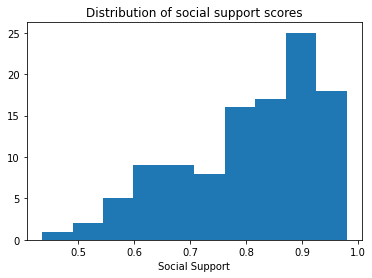

In [16]:
plt.hist(happiness_2021['Social support'])
plt.xlabel("Social Support")
plt.title("Distribution of social support scores")
plt.show()

### Hypothesis Testing and Regression
Regression analysis shows a high correlation between social support and happiness (Pearson's r value of 0.81). This correlation is statistically significant, given the p-value calculated in the null hypothesis test is well below 0.05.

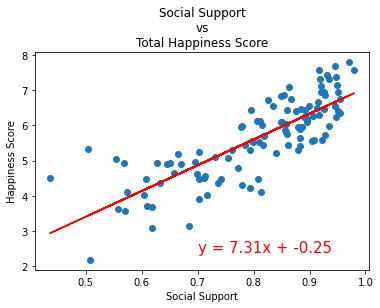

The correlation between social support and happiness is 0.81, suggesting a strong link between the two factors.


In [17]:
x_values = happiness_2021['Social support']
y_values = happiness_2021['Happiness score']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.7,2.4),fontsize=15,color="red")
plt.xlabel("Social Support")
plt.ylabel("Happiness Score")
plt.title("Social Support\nvs\nTotal Happiness Score")
plt.show()
pr = round(st.pearsonr(x_values,y_values)[0],2)
print(f'The correlation between social support and happiness is {pr}, suggesting a strong link between the two factors.')

In [18]:
# sort dataset and see how many values need to be in each group
h0_test = happiness_2021[["Country","Happiness score","Social support"]]
h0_test = h0_test.sort_values("Social support")

bottom_third = h0_test.iloc[0:37,1]
middle_third = h0_test.iloc[37:74,1]
top_third = h0_test.iloc[74:110,1]

stat,p = st.kruskal(top_third,middle_third,bottom_third)
print(f'The p-value is {p}, which rejects the null hypothesis.')

The p-value is 8.261872947301994e-16, which rejects the null hypothesis.


### Geographic Distribution of Social Support
Countries with the highest social support values are concentrated in Europe (particularly Scandanavia and Eastern Europe) as well as Central Asia. The countries with the lowest social support values are concentrated in Northern and Sub-Saharan Africa, the Middle East, South and South-East Asia. In the Americas, most countries fall into the middle tier of social support, with 6 landing in the top third. Mexico is the notable exception as the one country in the bottom third of nations. 

In [19]:
gmaps.configure(api_key = gkey)
fig = gmaps.figure()

social_sorted = happiness_2021.sort_values('Social support')
top_locations = social_sorted.iloc[74:110,[6,7]]
top_social = social_sorted.iloc[74:110,3]
middle_locations = social_sorted.iloc[37:74,[6,7]]
middle_social = social_sorted.iloc[37:74,3]
bottom_locations = social_sorted.iloc[0:37,[6,7]]
bottom_social = social_sorted.iloc[0:37,3]

figure_layout = {
    'width': '1000px',
    'height': '500px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto',
}
                             
fig = gmaps.figure(layout=figure_layout, center=(26.820553, 30.802498), zoom_level=1.75)

symbols_top = gmaps.symbol_layer(top_locations, fill_color='#028833', stroke_color='#028833')
fig.add_layer(symbols_top)

symbols_middle = gmaps.symbol_layer(middle_locations, fill_color='blue', stroke_color='blue')
fig.add_layer(symbols_middle)

symbols_bottom = gmaps.symbol_layer(bottom_locations, fill_color='#E65300', stroke_color='#E65300')
fig.add_layer(symbols_bottom)

fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', margin='0 auto 0 auto', padding='1px', wi…

In the above map, green dots represent the countries in the top third of social support values. Blue represents the middle third and orange represents the bottom third.

### We all need somebody to lean on
The results of comparing amount of social support to happiness in the study countries strongly suggests that social support positively influences happiness. Humans are social creatures, so it makes sense that having connections to others would increase happiness. 

# Conclusion

All four variables we analyzed - GDP per capita, freedom to make life choices, healthy life expectancy, and social support - all positively correlate in statistically significant ways to happiness score. 

Overall, this dataset was quite straightforward to work with. We had minor hiccups understanding which dataset published in the World Happiness Report was best for our needs, but that was relatively easily overcome and didn't waste too much time. Geocoding the countries presented a minor challenge in distinguishing between Georgia the country and Georgia the state in the USA! The address search in the Google Geocoding API returned the later; further research indicated it was necessary to specify `components=country:{country}` in the URL to return the correct result.